 # Stroke Rehab EEG Analysis Pipeline



 Pipeline to convert .mat files into MNE Raw and Epochs objects and store them in a structured DataFrame.

 ## 🧰 Setups and Imports

In [107]:
import os
import re
import mne
import numpy as np
from mne_features.feature_extraction import FeatureExtractor
import pandas as pd
from scipy.io import loadmat


 ## ⚙️ Constants Definition

In [2]:
DATA_DIR = './stroke-rehab-data-analysis/data/stroke-rehab'
FILE_REGEX = r'(?P<subject>P\d+)_(?P<stage>pre|post)_(?P<split>training|test)\.mat'
CHANNEL_NAMES = ['FC3','FCz','FC4','C5','C3','C1','Cz','C2','C4','C6', 'CP3','CP1','CPz','CP2','CP4','Pz']
CHANNEL_TYPES = ['eeg'] * len(CHANNEL_NAMES)
MONTAGE = 'standard_1020'
EVENT_ID={'left': 1, 'right': 2}


 ## 📂 Data File Paths Parsing

In [3]:
file_entries = []

for fname in os.listdir(DATA_DIR):
    match = re.match(FILE_REGEX, fname)
    if match:
        file_entries.append({
            'filepath': os.path.join(DATA_DIR, fname),
            'subject': match.group('subject'),
            'stage': match.group('stage'),
            'split': match.group('split'),
        })

df = pd.DataFrame(file_entries)
df.head(10)


,filepath,subject,stage,split
0,./stroke-rehab-data-analysis/data/stroke-rehab...,P1,post,test
1,./stroke-rehab-data-analysis/data/stroke-rehab...,P1,post,training
2,./stroke-rehab-data-analysis/data/stroke-rehab...,P1,pre,test
3,./stroke-rehab-data-analysis/data/stroke-rehab...,P1,pre,training
4,./stroke-rehab-data-analysis/data/stroke-rehab...,P2,post,test
5,./stroke-rehab-data-analysis/data/stroke-rehab...,P2,post,training
6,./stroke-rehab-data-analysis/data/stroke-rehab...,P2,pre,test
7,./stroke-rehab-data-analysis/data/stroke-rehab...,P2,pre,training
8,./stroke-rehab-data-analysis/data/stroke-rehab...,P3,post,test
9,./stroke-rehab-data-analysis/data/stroke-rehab...,P3,post,training


 ## 🧠 MNE Raw Objects Generation

In [4]:
def make_info(subject, stage, split, fs):
    """Create MNE info object with metadata."""
    info = mne.create_info(
        ch_names=CHANNEL_NAMES,
        sfreq=fs,
        ch_types=CHANNEL_TYPES
    )
    info.set_montage(MONTAGE)

    # Add metadata
    info['subject_info'] = {'his_id': subject}
    info['description'] = str({'stage': stage, 'split': split})

    return info

def make_annotations(triggers, fs):
    """Create annotations for the raw data."""
    # Create annotations based on the triggers
    padded = np.r_[0, triggers, 0]
    diffs = np.diff(padded)
    idx = np.where(diffs != 0)[0]
    onsets, offsets = idx[::2], idx[1::2]
    values = triggers[onsets]

    onset_times = onsets / fs
    annot_durations = (offsets - onsets) / fs
    annot_descriptions = ['left' if val == 1 else 'right' for val in values]

    annot = mne.Annotations(onset=onset_times,
                            duration=annot_durations,
                            description=annot_descriptions)
    
    return annot

def load_raw_from_mat(filepath, subject, stage, split):
    """Load raw data from .mat file."""
    mat = loadmat(filepath)
    data = mat['y'].T
    triggers = mat['trig'].ravel()
    fs = float(mat['fs'].squeeze())
    
    info = make_info(subject, stage, split, fs)

    raw = mne.io.RawArray(data, info)

    annot = make_annotations(triggers, fs)
    
    raw.set_annotations(annot)

    return raw


In [5]:
df['raw'] = df.apply(
    lambda row: load_raw_from_mat(row['filepath'], row['subject'], row['stage'], row['split']),
    axis=1
)


Creating RawArray with float64 data, n_channels=16, n_times=194088
    Range : 0 ... 194087 =      0.000 ...   758.152 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=197343
    Range : 0 ... 197342 =      0.000 ...   770.867 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=204560
    Range : 0 ... 204559 =      0.000 ...   799.059 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=271816
    Range : 0 ... 271815 =      0.000 ...  1061.777 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=233576
    Range : 0 ... 233575 =      0.000 ...   912.402 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=216720
    Range : 0 ... 216719 =      0.000 ...   846.559 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=199552
    Range : 0 ... 199551 =      0.000 ...   779.496 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=223112
    Range : 0 ..

In [6]:
# Select the simple string columns
meta = df[["subject", "stage", "split"]]
# Create a new DataFrame with the types of the objects
types = df[["raw"]].map(lambda x: type(x).__name__)
# Concatenate both for display
pd.concat([meta, types], axis=1)

,subject,stage,split,raw
0,P1,post,test,RawArray
1,P1,post,training,RawArray
2,P1,pre,test,RawArray
3,P1,pre,training,RawArray
4,P2,post,test,RawArray
5,P2,post,training,RawArray
6,P2,pre,test,RawArray
7,P2,pre,training,RawArray
8,P3,post,test,RawArray
9,P3,post,training,RawArray


 ## ✂️ MNE Epochs Objects Generation

In [168]:
def create_epochs_from_raw(raw):
    fs = raw.info['sfreq']
    events, event_id = mne.events_from_annotations(raw, event_id=EVENT_ID)
    events[:, 0] += int(2 * fs)  # Shift events forward 2s per task description
    epochs = mne.Epochs(raw, events, event_id=event_id,preload=True)
    return epochs


In [8]:
df['epochs'] = df['raw'].apply(create_epochs_from_raw)


Used Annotations descriptions: [np.str_('left'), np.str_('right')]
Not setting metadata
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: [np.str_('left'), np.str_('right')]
Not setting metadata
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: [np.str_('left'), np.str_('right')]
Not setting metadata
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: [np.str_('left'), np.str_('right')]
Not setting metadata
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: [np.str_('left'), np.str_('right'

 ## 🧾 Final DataFrame Structure

In [9]:
# Select the simple string columns
meta = df[["subject", "stage", "split"]]
# Create a new DataFrame with the types of the objects
types = df[["raw","epochs"]].map(lambda x: type(x).__name__)
# Concatenate both for display
pd.concat([meta, types], axis=1)

,subject,stage,split,raw,epochs
0,P1,post,test,RawArray,Epochs
1,P1,post,training,RawArray,Epochs
2,P1,pre,test,RawArray,Epochs
3,P1,pre,training,RawArray,Epochs
4,P2,post,test,RawArray,Epochs
5,P2,post,training,RawArray,Epochs
6,P2,pre,test,RawArray,Epochs
7,P2,pre,training,RawArray,Epochs
8,P3,post,test,RawArray,Epochs
9,P3,post,training,RawArray,Epochs


In [18]:

def filtration(raw,l_freq=0.5,h_freq=40):
    raw_filtered=raw.copy().filter(l_freq=0.5, h_freq=40.)
    return(raw_filtered)


In [12]:
def apply_ica(raw):
    ica = ICA(n_components=raw.get_data().shape[0], random_state=42, max_iter='auto')
    ica.fit(raw_filt)
    return ica



In [33]:
def BLI(raw):
    psd, freqs=mne.time_frequency.psd_array_welch(raw.get_data(), sfreq=256,fmin=0.5,fmax=40.,n_fft=256)
    psds_band = psd.mean(axis=1) 
    channel_pairs = [
        ('FC3', 'FC4'),
        ('C5', 'C6'),
        ('C3', 'C4'),
        ('C1', 'C2'),
        ('CP3', 'CP4'),
        ('CP1', 'CP2')
    ]
    ch_names=raw.info['ch_names']
    bsi_vals = []
    for ch_left, ch_right in channel_pairs:
        if ch_left in ch_names and ch_right in ch_names:
            idx_left = ch_names.index(ch_left)
            idx_right = ch_names.index(ch_right)
            P_left = psds_band[idx_left]
            P_right = psds_band[idx_right]
            denom = P_left + P_right
            if denom > 0:
                bsi = abs(P_left - P_right) / denom
                bsi_vals.append(bsi)
    return(pd.concat([
        pd.Series(channel_pairs,name='channel_pair'), 
        pd.Series(bsi_vals,name='bsi_value')],axis=1
        )
           )

BLI(raw)

Effective window size : 1.000 (s)


,channel_pair,bsi_value
0,"(FC3, FC4)",0.142717
1,"(C5, C6)",0.111770
2,"(C3, C4)",0.181111
3,"(C1, C2)",0.100598
4,"(CP3, CP4)",0.126475
5,"(CP1, CP2)",0.060950


In [66]:
raw_filtered=[filtration(raw)for raw in raw_list]
bsi_list=[BLI(raw)for raw in raw_filtered]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband ed

In [63]:
BLI(raw2)['bsi_value']

Effective window size : 1.000 (s)


0    0.090170
1    0.187555
2    0.144449
3    0.012183
4    0.164254
5    0.004885
Name: bsi_value, dtype: float64

In [64]:
BLI(raw0)['bsi_value']-BLI(raw2)['bsi_value']

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


0    0.047341
1   -0.062009
2    0.034051
3    0.083588
4   -0.036027
5    0.057500
Name: bsi_value, dtype: float64

In [ ]:
freq_bands = {f'mu_band': (8.0, 13.0)}
selected_funcs = ['pow_freq_bands']
feature_extractor = FeatureExtractor(
    sfreq=epochs.info['sfreq'], 
    selected_funcs=selected_funcs, 
    params={'pow_freq_bands__freq_bands': freq_bands},
    n_jobs=N_CORES,
    memory=cache_path
)

In [278]:
epochs_left_0=df['epochs'][0]['left'].get_data()

epochs_rigth_0=df['epochs'][0]['right'].get_data()
def BLI(raw,ch_names=raw.info['ch_names']):
    psd, freqs=mne.time_frequency.psd_array_welch(raw, sfreq=256,fmin=0.5,fmax=40.,n_fft=90)
    psds_band = psd.mean(axis=1) 
    channel_pairs = [
        ('FC3', 'FC4'),
        ('C5', 'C6'),
        ('C3', 'C4'),
        ('C1', 'C2'),
        ('CP3', 'CP4'),
        ('CP1', 'CP2')
    ]
    bsi_vals = []
    for ch_left, ch_right in channel_pairs:
        if ch_left in ch_names and ch_right in ch_names:
            idx_left = ch_names.index(ch_left)
            idx_right = ch_names.index(ch_right)
            P_left = psds_band[idx_left]
            P_right = psds_band[idx_right]
            denom = P_left + P_right
            if denom > 0:
                bsi = abs(P_left - P_right) / denom
                bsi_vals.append(bsi)
    return(pd.concat([
        pd.Series(channel_pairs,name='channel_pair'), 
        pd.Series(bsi_vals,name='bsi_value')],axis=1
        )
           )


Using data from preloaded Raw for 40 events and 180 original time points ...
Using data from preloaded Raw for 40 events and 180 original time points ...


In [201]:
df['epochs']
raw.info

<Info | 10 non-empty values
 bads: []
 ch_names: FC3, FCz, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, CP1, CPz, CP2, ...
 chs: 16 EEG
 custom_ref_applied: False
 description: {'stage': 'post', 'split': 'test'}
 dig: 19 items (3 Cardinal, 16 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 16
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: P1>
>

In [388]:
def compute_bli_left_right(epochs_list, l_freq=8., h_freq=13.):
    bli_left_all = []
    bli_right_all = []

    for epochs in epochs_list:
        ep = epochs.copy()
        ep.load_data()
        ep.filter(l_freq=l_freq, h_freq=h_freq)

        data_left = ep['left'].get_data()
        bli_left = [BLI(e) for e in data_left]
        bli_left_all.append(bli_left)

        data_right = ep['right'].get_data()
        bli_right = [BLI(e) for e in data_right]
        bli_right_all.append(bli_right)

    return bli_left_all, bli_right_all


In [309]:
%%capture
bli_left, bli_right = compute_bli_left_right(df['epochs'])

In [367]:


def extract_pair_electrodes(data, index):

    # Lista vacía para almacenar los resultados de cada clase
    result_list = []
    
    # Iterar sobre cada clase (bloque de datos) en la lista de listas
    for epoch in data:
        electrode_values=[]
        for df in epoch:
        # Extraer el DataFrame correspondiente
            pair_data = df.iloc[index]['bsi_value']
        
        # Extraemos el valor del par de electrodos (por ejemplo, C3 y C4) y lo almacenamos como array
            electrode_values.append(pair_data)  # Se asume que el DataFrame tiene una columna de valores

        # Añadimos los valores al resultado final como un array
        result_list.append(electrode_values)
    
    # Retornamos la lista de arrays
    return result_list

In [368]:
C3_C4_left=extract_pair_electrodes(bli_left,2)
C3_C4_right=extract_pair_electrodes(bli_right,2)

In [395]:
subjects = ['P1', 'P2', 'P3']
C3_C4_data = {}

for i, subject in enumerate(subjects):
    idx = i * 4
    C3_C4_data[f'{subject}_left_post_train'] = np.concatenate([C3_C4_left[idx], C3_C4_left[idx + 1]])
    C3_C4_data[f'{subject}_left_pre_train'] = np.concatenate([C3_C4_left[idx + 2], C3_C4_left[idx + 3]])
    C3_C4_data[f'{subject}_right_post_train'] = np.concatenate([C3_C4_left[idx], C3_C4_right[idx + 1]])
    C3_C4_data[f'{subject}_right_pre_train'] = np.concatenate([C3_C4_left[idx + 2], C3_C4_right[idx + 3]])



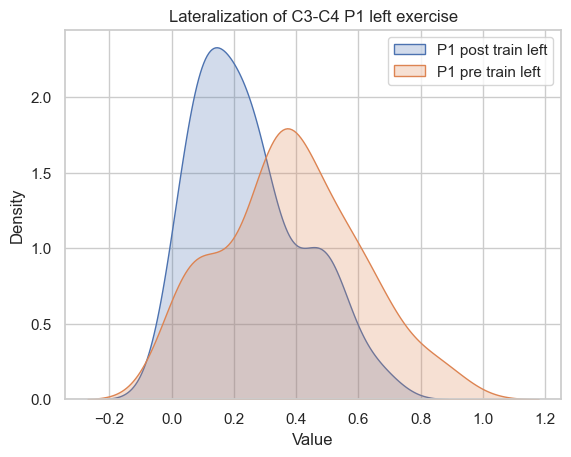

In [396]:
import seaborn as sns
sns.kdeplot(C3_C4_data['P1_left_post_train'], label='P1 post train left', fill=True)
sns.kdeplot(C3_C4_data['P1_left_pre_train'], label='P1 pre train left', fill=True)
plt.title("Lateralization of C3-C4 P1 left exercise")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

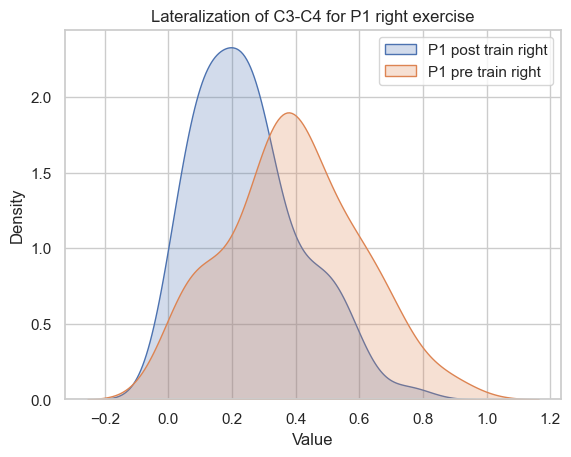

In [397]:
import seaborn as sns
sns.kdeplot(C3_C4_data['P1_right_post_train'], label='P1 post train right', fill=True)
sns.kdeplot(C3_C4_data['P1_right_pre_train'], label='P1 pre train right', fill=True)
plt.title("Lateralization of C3-C4 for P1 right exercise")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
diff_left_P1=diff_BLI(bli_left[0],bli_left[1])
diff_right_P1=diff_BLI(bli_list_P1_right_post_train,bli_list_P1_right_pre_train)

diff_left_P2=diff_BLI(bli_list_P2_left_post_train,bli_list_P2_left_pre_train)
diff_right_P2=diff_BLI(bli_list_P2_right_post_train,bli_list_P2_right_pre_train)

diff_left_P3=diff_BLI(bli_list_P3_left_post_train,bli_list_P3_left_pre_train)
diff_right_P3=diff_BLI(bli_list_P3_right_post_train,bli_list_P3_right_pre_train)

In [ ]:
def merge_pairs(df_list):
    """
    Une pares consecutivos de DataFrames de una lista.
    Retorna una lista de DataFrames concatenados.
    """
    merged = []
    for i in range(0, len(df_list), 2):
        merged.append(df_list[i]+df_list[i+1])
    return merged


In [ ]:
total_left=merge_pairs(bli_left)
total_right=merge_pairs(bli_right)

C3_C4_left=extract_pair_electrodes(total_left,2)
C3_C4_right=extract_pair_electrodes(total_right,2)

In [444]:
def diff_BLI(bli1, bli2):
    """
    Calcula la diferencia entre las columnas 'bsi_value' de los DataFrames en 
    las listas 'bli1' y 'bli2'. Devuelve una lista de DataFrames con la columna
    'channel_pair' y la columna 'diff' con las diferencias calculadas.

    Parameters:
    - bli1: Lista de DataFrames (cada uno con columnas 'channel_pair' y 'bsi_value')
    - bli2: Lista de DataFrames (cada uno con columnas 'channel_pair' y 'bsi_value')

    Returns:
    - diff_list: Lista de DataFrames, cada uno con las columnas 'channel_pair' y 'diff'.
    """
    
    diff_list = []

    for df1, df2 in zip(bli1, bli2):
        # Verificamos que los DataFrames tienen la misma longitud
        if len(df1) != len(df2):
            raise ValueError("Los DataFrames no tienen el mismo número de filas")
        
        # Calculamos la diferencia entre los valores de 'bsi_value' en los dos DataFrames
        diff = df1['bsi_value'].reset_index(drop=True) - df2['bsi_value'].reset_index(drop=True)
        
        # Creamos un nuevo DataFrame con los pares de canales y las diferencias
        superdiff = pd.DataFrame({
            'channel_pair': df1['channel_pair'],  # Usamos los pares de canales del primer DataFrame
            'diff': diff  # La diferencia entre los valores de 'bsi_value'
        })

        # Agregamos el DataFrame resultante a la lista
        diff_list.append(superdiff)

    return diff_list
diff_left_P1=diff_BLI(total_left[0],total_left[1])
diff_left_P2=diff_BLI(total_left[2],total_left[3])
diff_left_P3=diff_BLI(total_left[4],total_left[5])

diff_right_P1=diff_BLI(total_right[0],total_right[1])
diff_right_P2=diff_BLI(total_right[2],total_right[3])
diff_right_P3=diff_BLI(total_right[4],total_right[5])

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [445]:
from scipy.stats import ttest_1samp
C3_C4_diff_P1_left = [df.loc[2, 'diff'] for df in diff_left_P1]
C3_C4_diff_P1_right = [df.loc[2, 'diff'] for df in diff_right_P1]
C3_C4_diff_P2_left = [df.loc[2, 'diff'] for df in diff_left_P2]
C3_C4_diff_P2_right = [df.loc[2, 'diff'] for df in diff_right_P2]
C3_C4_diff_P3_left = [df.loc[2, 'diff'] for df in diff_left_P3]
C3_C4_diff_P3_right = [df.loc[2, 'diff'] for df in diff_right_P3]



In [446]:
import pandas as pd
from scipy.stats import ttest_1samp

# Assuming you already have these variables:
# C3_C4_diff_P1_left, C3_C4_diff_P1_right, ..., C3_C4_diff_P3_right

# List of conditions
conditions = [
    ("P1 left", C3_C4_diff_P1_left),
    ("P1 right", C3_C4_diff_P1_right),
    ("P2 left", C3_C4_diff_P2_left),
    ("P2 right", C3_C4_diff_P2_right),
    ("P3 left", C3_C4_diff_P3_left),
    ("P3 right", C3_C4_diff_P3_right),
]

# Perform t-test and store results in a list
results = []
for name, data in conditions:
    t_stat, p_val = ttest_1samp(data, popmean=0)
    results.append({
        "Condition": name,
        "t-stat": round(t_stat, 4),
        "p-value": round(p_val, 4)
    })

# Create DataFrame
df_results = pd.DataFrame(results)

# Display the table
print(df_results)

  Condition  t-stat  p-value
0   P1 left -4.2861   0.0001
1  P1 right -4.5490   0.0000
2   P2 left -3.2625   0.0016
3  P2 right -1.2434   0.2174
4   P3 left -1.4582   0.1488
5  P3 right  1.3527   0.1800
